Assignment 3: 

Name: Ameya Vishwanath Konkar

UID: 118191058

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 

In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Part 1: Epipolar Geometry (30 Points)


## Overview

In this problem, you will implement an algorithm for automatically estimating homography with RANSAC. In the file matches.mat, we provide the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://drive.google.com/uc?id=17mwO8QH24vw1Kv1aBONgFXKi53HqUMEd&export=download" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://drive.google.com/uc?id=1nVnvBpKeLmiowT9Q4_QauogXpcdXBmHm&export=download" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 63.9MB/s]
Archive:  /content/Part1_data.zip
   creating: /content/Part1_data/
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


In [ ]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]
# print(matches)

## Helper Functions

In [ ]:
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()


### Code (15 pt)

In [ ]:
def ransacF(x1, y1, x2, y2):
  # Find normalization matrix
  # Transform point set 1 and 2
  # RANSAC based 8-point algorithm
  # YOUR CODE HERE:
  import random

  n_iter = 15000
  thresh = 0.01
  min_count = 0
  F_final = []
  final_pts = []
  for i in range(n_iter):
      indexes = [random.randint(0, x1.shape[0]-1) for _ in range(8)]
      pt1_x = x1[indexes]
      pt1_y = y1[indexes]
      pt2_x = x2[indexes]
      pt2_y = y2[indexes]
      F_norm = computeF(pt1_x, pt1_y, pt2_x, pt2_y)
      try:
        pts1 = np.vstack((x1.T, y1.T, np.ones(x1.shape[0]))).T
        pts2 = np.vstack((x2.T, y2.T, np.ones(x1.shape[0]))).T
        thresh_pts = getInliers(pts1, pts2, F_norm, thresh)
        if(thresh_pts.shape[0] > min_count):
          pts1
          F_final = F_norm
      except:
        continue
    
  return F_final

def getInliers(pts1, pts2, F_norm, thresh):
  # Function: implement the criteria checking inliers. 
  # YOUR CODE HERE:
  threshold = pts2.dot(F_norm).dot(pts1.T)
  thresh_pts = np.array(np.where(np.diag(threshold) < thresh)).reshape(-1)
  return thresh_pts


def normalize(x, y):
  # Function: find the transformation to make it zero mean and the variance as sqrt(2)
  # YOUR CODE HERE: 

  mean_x = np.mean(x.copy())
  mean_y = np.mean(y.copy())
  
  s_x = x - mean_x
  s_y = y - mean_y

  s = (2/np.mean(s_x**2 + s_y**2))**0.5

  T1 = np.matrix([[s, 0, 0],
                 [0, s, 0],
                 [0, 0, 1]])
  T2 = np.matrix([[1, 0, -mean_x],
                  [0, 1, -mean_y],
                  [0, 0, 1]])
  T = T1.dot(T2)

  pts = np.vstack((x1.T, y1.T, np.ones(x1.shape[0])))

  normalized_pts = T.dot(pts)

  return T, normalized_pts

  
def computeF(x1_, y1_, x2_, y2_):
  #  Function: compute fundamental matrix from corresponding points
  # YOUR CODE HERE: 
  pts1 = np.vstack((x1_.T, y1_.T)).T
  pts2 = np.vstack((x2_.T, y2_.T)).T
  
  F = find_fundamental_matrix(pts1, pts2)
  #F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)
  return F

def find_fundamental_matrix(src_points, dst_points):
    def reduce_f_mat_rank():
        u_f, s_f, vh_f = np.linalg.svd(F)
        s_f[-1] = 0
        F_new = np.matmul(u_f*s_f, vh_f)
        return F_new

    A_mat = []
    row = []

    for i in range(len(src_points)):
        row.append(src_points[i, 0]*dst_points[i, 0])     # x*x_dash
        row.append(src_points[i, 0]*dst_points[i, 1])     # x*y_dash
        row.append(src_points[i, 0])                      # x
        row.append(src_points[i, 1]*dst_points[i, 0])     # y*x_dash
        row.append(src_points[i, 1]*dst_points[i, 1])     # y*y_dash
        row.append(src_points[i, 1])                      # y
        row.append(dst_points[i, 0])                      # x_dash
        row.append(dst_points[i, 1])                      # y_dash
        row.append(1)                                     # 1
        rc = row.copy()
        A_mat.append(rc)
        row.clear()
    
    u, s, vh = np.linalg.svd(A_mat)
    x = vh[-1]
    
    F = np.reshape(x, [3,3])

    if np.linalg.matrix_rank(F) == 3:
        F = reduce_f_mat_rank()  

    return F

def display_img(img1, img2, x1, y1, x2, y2, F):

  indexes = [random.randint(0, x1.shape[0]-1) for _ in range(7)]
  pt1_x = x1[indexes]
  pt1_y = y1[indexes]
  pt2_x = x2[indexes]
  pt2_y = y2[indexes]
  
  pts1 = np.vstack((pt1_x.T, pt1_y.T, np.ones(pt1_x.shape[0])))
  pts2 = np.vstack((pt2_x.T, pt2_y.T, np.ones(pt2_x.shape[0])))

  print(pts1)

  line1 = F.dot(pts1).T
  line2 = F.dot(pts2).T

  
  img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
  img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

  pt1_x = pt1_x.reshape(-1)
  pt1_y = pt1_y.reshape(-1)
  pt2_x = pt2_x.reshape(-1)
  pt2_y = pt2_y.reshape(-1)

  print(pt1_x.shape)

  for i in range(7):
    l1 = np.array(line1[i]).flatten()
    l2 = np.array(line2[i]).flatten()
    
    img1 = cv2.circle(img1, (pt1_x[i], pt1_y[i]), 5, (255, 0, 0), -1)
    l1_y1 = (-l1[2]/l1[1])
    l1_x1 = 0
    
    l1_y2 = ((-(img1.shape[1]-1)*l1[0] - l1[2])/l1[1])
    l1_x2 = img1.shape[1]-1

    img1 = cv2.line(img1, (int(l1_x1), int(l1_y1)), (int(l1_x2), int(l1_y2)), (0, 255, 0), 1) 

    img2 = cv2.circle(img2, (pt2_x[i], pt2_y[i]), 5, (255, 0, 0), -1)
    l2_y1 = (-l2[2]/l2[1])
    l2_x1 = 0
    
    l2_y2 = ((-(img1.shape[1]-1)*l2[0] - l2[2])/l2[1])
    l2_x2 = img1.shape[1]-1

    img2 = cv2.line(img2, (int(l2_x1), int(l2_y1)), (int(l2_x2), int(l2_y2)), (0, 255, 0), 1) 

  fig = plt.figure(figsize=(30, 21))

  fig.add_subplot(2, 2, 1)
  plt.imshow(img1)
  plt.axis('off')
  plt.title("First")

  # Adds a subplot at the 2nd position
  fig.add_subplot(2, 2, 2)
    
  # showing image
  # show_image(img2, scale=1.0)
  plt.imshow(img2)
  plt.axis('off')
  plt.title("Second")

[[ 1.13440001e-13 -3.27750260e-06  2.03945477e-03]
 [ 3.27751310e-06 -4.59870426e-11  1.50446509e-01]
 [-2.03945635e-03 -1.50446498e-01 -4.99501414e-07]]

[[133. 276. 497. 169. 138. 453. 374.]
 [128. 231. 220. 231.  86.  94. 181.]
 [  1.   1.   1.   1.   1.   1.   1.]]
(7,)


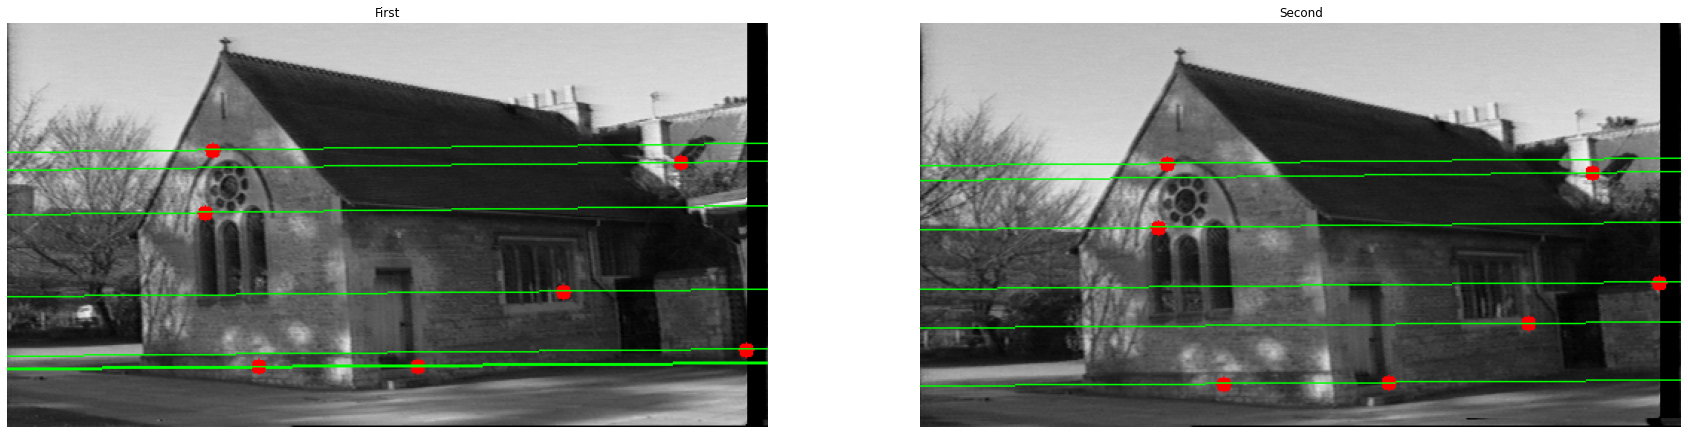

In [ ]:
T1, norm_pts_1 = normalize(x1.copy(), y1.copy())

T2, norm_pts_2 = normalize(x2.copy(), y2.copy())

norm_pts_1 = norm_pts_1.T
norm_pts_2 = norm_pts_2.T

norm_x1 = norm_pts_1[:, 0]
norm_y1 = norm_pts_1[:, 1]

norm_x2 = norm_pts_2[:, 0]
norm_y2 = norm_pts_2[:, 1]

F_dash = ransacF(norm_x1, norm_y1, norm_x2, norm_y2)
F = T2.T.dot(F_dash).dot(T1)

# F, mask = cv2.findFundamentalMat(,pts2,cv2.RANSAC)
print()
img1  = plt.imread("/content/Part1_data/chapel00.png")
  # show_image(img1, scale = 4.0)

img2  = plt.imread("/content/Part1_data/chapel01.png")
display_img(img1, img2, x1, y1, x2, y2, F)

### Write-up (15 pt)
*   Describe what test you used for deciding inlier vs. outlier.
1. I used RANSAC algorithm to select inliers. The **x2_norm.T.F_norm.x1_norm < threshold** condition after determining the Fundamental matrix is used to determine if two pairs of points are inliers  




*   Display the estimated fundamental matrix F after normalizing to unit length


In [ ]:
print(F)

[[ 1.13440001e-13 -3.27750260e-06  2.03945477e-03]
 [ 3.27751310e-06 -4.59870426e-11  1.50446509e-01]
 [-2.03945635e-03 -1.50446498e-01 -4.99501414e-07]]


*   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.

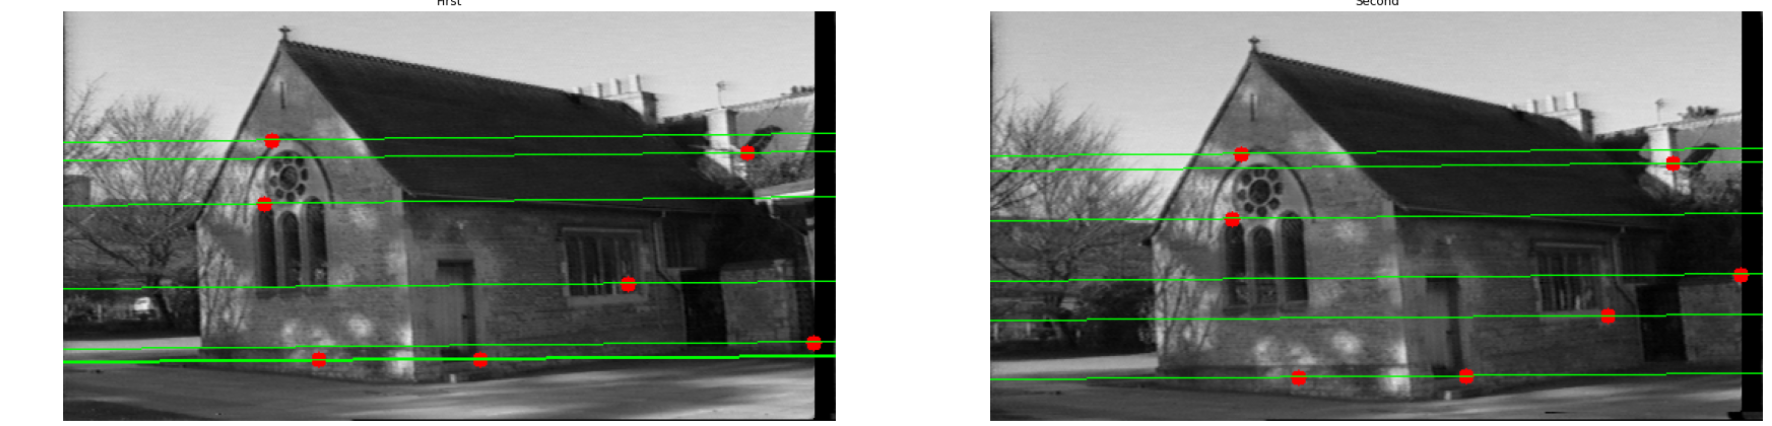

### Hint

*   You can use cv2.cornerHarris in opencv.
*   For visualization, you can use cv2.line, cv2.circle or any other helper functions in opencv or matplotlib.


# Part 2: Image stitching (30 points)

<img src="https://drive.google.com/uc?id=1uOI8rpqb_FsR9Fi8GrGPZvICOcgflBj9&export=download" width="800"/>

## Overview

In this problem, you will implement an algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm. 

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images

**Note:**  Do not use existing image stitching code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 98.5MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 84.1MB/s]
Archive:  /content/tv.zip
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


## Helper Functions

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(images, feature_coord, matches, img_idx):
    matched_img = drawMatches(images[img_idx], feature_coord[img_idx], images[img_idx-1], 
                              feature_coord[img_idx-1], matches[img_idx-1])

    cv2.imshow('Matches Found', matched_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [ ]:
from typing_extensions import final
from google.colab.patches import cv2_imshow

def imageStitch(img1, img2):

    def detectKeypts(img1, img2):
      img1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
      img2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

      orb = cv2.ORB_create()

      # find the keypoints and descriptors with SIFT
      kp1, des1 = orb.detectAndCompute(img1,None)
      kp2, des2 = orb.detectAndCompute(img2,None)

      return kp1, des1, kp2, des2

    def matchdes(kp1, des1, kp2, des2): 
      # create BFMatcher object
      index_params = dict(algorithm=6,
                        table_number=6,
                        key_size=12,
                        multi_probe_level=2)
      search_params = {}
      flann = cv2.FlannBasedMatcher(index_params, search_params)
      matches = flann.knnMatch(des1, des2, k=2)

      # As per Lowe's ratio test to filter good matches
      good_matches = []
      for m, n in matches:
          if m.distance < 0.6 * n.distance:
              good_matches.append(m)

      src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
      dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

      return src_pts, dst_pts
    
    def showMatches(list_kp1, list_kp2, img1, img2):
        for i in range(len(list_kp1)):
          img1 = cv2.circle(img1, (int(list_kp1[i][0]), int(list_kp1[i][1])), 3, (255, 0, 0), -1)
        
        for i in range(len(list_kp1)):
          img2 = cv2.circle(img2, (int(list_kp2[i][0]), int(list_kp2[i][1])), 3, (255, 0, 0), -1)
        
        cv2_imshow(img1)
        cv2_imshow(img2)

    def ransac(ptx_2, ptx_1):
      
      n_iter = 10000
      thresh = 0.02
      max_count = 0
      H_fin = []
      for i in range(n_iter):
        indexes = [random.randint(0, list_kp2.shape[0]-1) for _ in range(7)]
        pt1 = ptx_1[indexes]
        pt2 = ptx_2[indexes]

        H_norm = est_homography(pt2, pt1)
        
        pt_test = np.vstack((ptx_2[:,0].T, ptx_2[:,1].T, np.ones(ptx_2.shape[0])))
        res = H_norm.dot(pt_test).T
        pt_test = np.divide(res,res[:, -1].reshape(res.shape[0], 1))

        dist = np.linalg.norm((pt_test[:,:2] - ptx_1),axis = 1)

        if np.count_nonzero(dist < thresh) > max_count:
            max_count = np.count_nonzero(dist < thresh)
            H_fin = H_norm
      
      return H_fin

    def get_normalize_pts(x, y):
      mean_x = np.mean(x.copy())
      mean_y = np.mean(y.copy())
      
      s_x = x - mean_x
      s_y = y - mean_y

      s = (2/np.mean(s_x**2 + s_y**2))**0.5

      T = np.matrix([[s, 0, -s*mean_x],
                     [0, s, -s*mean_y],
                     [0, 0, 1]])

      pts = np.vstack((x.T, y.T, np.ones(x.shape[0])))

      normalized_pts = T.dot(pts)

      return T, normalized_pts

  ###################################################################

    kp1, des1, kp2, des2 = detectKeypts(img1.copy(), img2.copy())
    list_kp1, list_kp2 = matchdes(kp1, des1, kp2, des2)
    
    list_kp1 = list_kp1.reshape(-1,2)
    list_kp2 = list_kp2.reshape(-1,2)
    
    # showMatches(list_kp1, list_kp2, img1.copy(), img2.copy())
    
    x_1 = list_kp1[:,0]
    y_1 = list_kp1[:,1]
    x_2 = list_kp2[:,0]
    y_2 = list_kp2[:,1]

    T1, norm_pts1 = get_normalize_pts(x_1, y_1)
    T2, norm_pts2 = get_normalize_pts(x_2, y_2)

    norm_pts1 = norm_pts1.T[:, 0:2]
    norm_pts2 = norm_pts2.T[:, 0:2]
    
    # print(norm_pts1)
    
    # print(norm_pts1)
    H_norm = ransac(norm_pts2, norm_pts1)
    H = np.linalg.inv(T1).dot(H_norm).dot(T2)

    pt_test = np.vstack((x_2.T, y_2.T, np.ones(x_2.shape[0])))
    pt2 = H.dot(pt_test).T/H.dot(pt_test).T[:,-1]

    max_x = img1.shape[0] + img2.shape[0]
    max_y = img1.shape[1] + img2.shape[1]
    
    final_img = np.zeros((max_x, max_y, 3))

    res = cv2.warpPerspective(img2, H,(max_y, max_x))

    final_img = res[:,:]
    final_img[0:img1.shape[0], 0: img1.shape[1]] =  cv2.max(final_img[0:img1.shape[0], 0: img1.shape[1]],img1[:, :])
    
    max_x = np.max(np.array(np.nonzero(final_img))[0].T)
    max_y = np.max(np.array(np.nonzero(final_img))[1].T)
    
    print(max_x, max_y)
    return final_img, max_x, max_y, H          


### Code (15 pt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


299 595
299 808


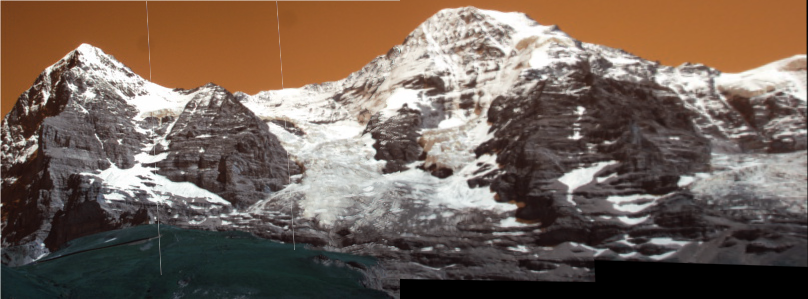

In [ ]:
# YOUR CODE HERE: 
import matplotlib.pyplot as plt
from matplotlib import cm

im1 = plt.imread("/content/hill/1.JPG")
im2 = plt.imread("/content/hill/2.JPG")
im3 = plt.imread("/content/hill/3.JPG")

# im1 = plt.imread("/content/tv/1.jpg")
# im2 = plt.imread("/content/tv/2.jpg")
# im3 = plt.imread("/content/tv/3.jpg")

x_m = 0
y_m = 0

H_fin = []
for i in range(2):
  im1, x_m, y_m, H_fin = imageStitch(im1.copy(), im2.copy())
  im2 = im3

sb_img = np.zeros((x_m, y_m))
sb_img = im1[0:x_m, 0:y_m]

cv2_imshow(sb_img)

### Write-up (15 pt)
*  Describe how to remove incorrect matches with RANSAC
1. Randomly select 8 matching pairs  
2. Compute homography matrix for the selected points
3. Using the Homography matrix find the maximum number of points that satisfy the condition (pt_new - pt2) < threshold, where, pt_new = pt1.dot(H)
4. If the number of inliers found is greater than previously found inliers, save the matrix 
5. Perform steps 1-4 n number of times

*  Display the best homography H after RANSAC 

In [ ]:
print(H_fin)

[[-3.45632226e-01 -1.97746631e-02 -2.84606791e+02]
 [ 1.12968591e-01 -6.20022511e-01 -6.68509055e+00]
 [ 4.48131751e-04 -8.42448458e-05 -6.02108712e-01]]


*  Display the blended images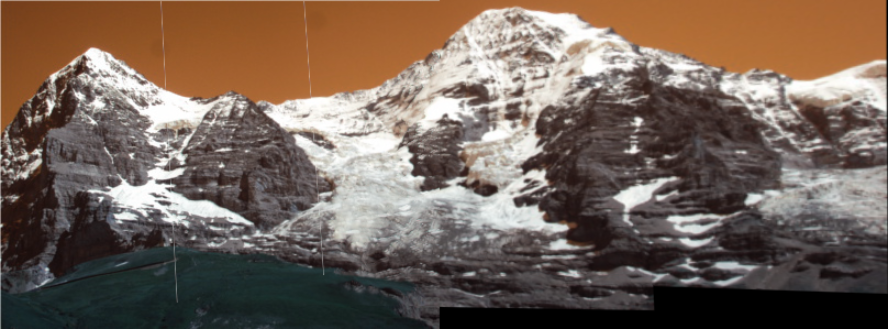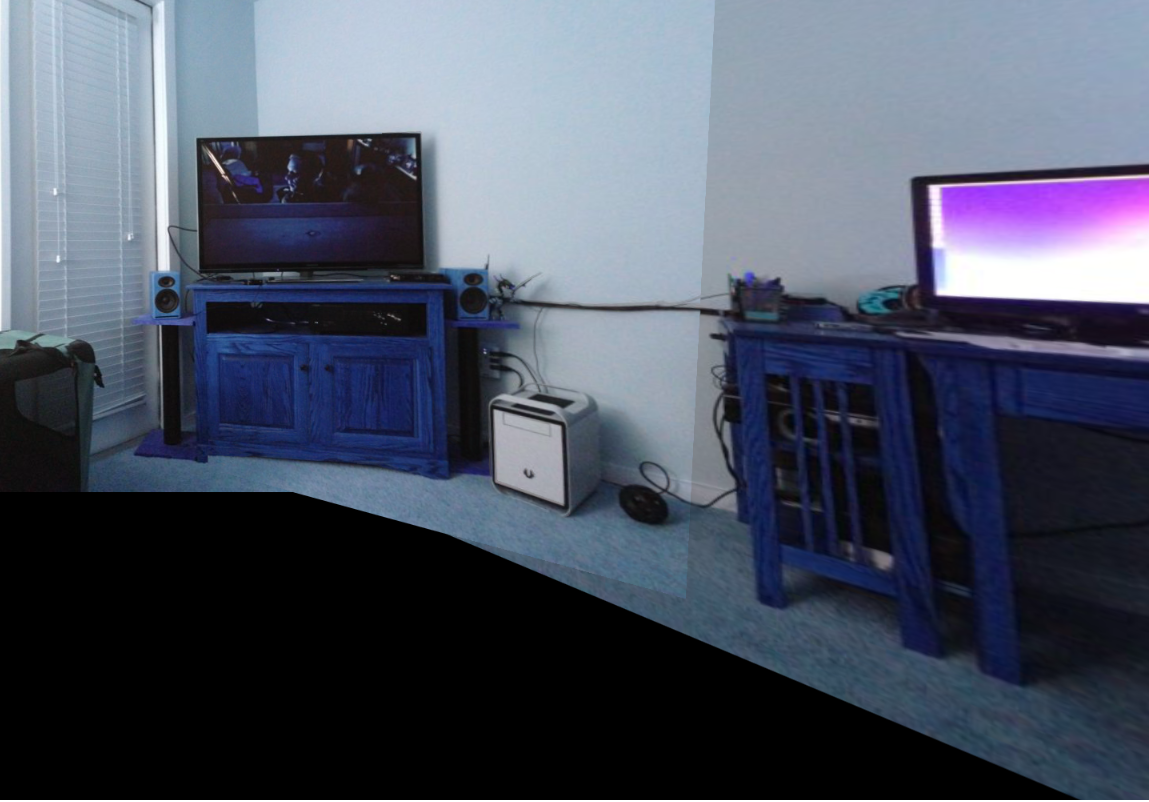

### Hint


*   Use Harris Corner Detection to find keypoint. You can use cv2.cornerHarris in opencv.
*   For image warping and blending, you should first deterimne canvas size. You can use cv2.warpPerspective in opencv. 


# Part 3: Affine Structure from Motion (40 points)

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 151MB/s]
Archive:  /content/Part2_data.zip
replace /content/Part2_data/images/hotel.seq0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Code (20 pt)

In [ ]:
track_x = data['track_x']
track_y = data['track_y']

# Remove the nan value
# YOUR CODE HERE
nan_values = np.unique(np.array(np.where(np.isnan(track_x)))[0])
track_x = np.delete(track_x, nan_values, 0)
track_y = np.delete(track_y, nan_values, 0)

def constructDMat(x_sfm, y_sfm):
  m, n = x_sfm.shape
  D = np.zeros((2*m, n))
  j = 0
  for i in range(0, 2*m, 2):
    D[i] = x_sfm[j]
    D[i+1] = y_sfm[j]
    j += 1
  return D

def computeSVDforD(D):
  U, S, V_T = np.linalg.svd(D)
  S = np.diag(S)
  U3 = U[:, :3]
  W3 = S[:3, :3]
  V3_T = V_T[:3, :]
  A = U3.dot(np.sqrt(W3))
  S = np.sqrt(W3).dot(V3_T)
  return A, S
  
def computeL(A):
  x1_sfm = A[::2]
  x2_sfm = A[1::2]
  # eqn1 = np.reshape(x1_sfm.T.dot(x1_sfm), (1, 9))
  # eqn2 = np.reshape(x2_sfm.T.dot(x2_sfm), (1, 9))
  # eqn3 = np.reshape(x1_sfm.T.dot(x2_sfm), (1, 9))
  eqn1 = np.zeros((int(A.shape[0]/2), 9))
  eqn2 = np.zeros((int(A.shape[0]/2), 9))
  eqn3 = np.zeros((int(A.shape[0]/2), 9))

  for i in range(int(A.shape[0]/2)):
    x1_temp = np.reshape(x1_sfm[i], (1,-1))
    x2_temp = np.reshape(x2_sfm[i], (1,-1))

    p1 = np.reshape(x1_temp.T.dot(x1_temp), (1, 9))
    p2 = np.reshape(x2_temp.T.dot(x2_temp), (1, 9))
    p3 = np.reshape(x1_temp.T.dot(x2_temp), (1, 9))
    eqn1[i] = p1
    eqn2[i] = p2
    eqn3[i] = p3
    
  X = np.vstack((eqn1, eqn2, eqn3))
  Y = np.vstack((np.ones((A.shape[0], 1)), np.zeros((int(A.shape[0]/2),1))))
  X_inv = np.linalg.pinv(X).dot(Y)

  return X_inv.reshape(3, 3)

def CholeskyDecomposition(L):
    return np.linalg.cholesky(L)

def affineSFM(x, y, o1, o2):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  # YOUR CODE HERE
  mean_x = np.mean(track_x, axis = 0).reshape(1, -1)
  mean_y = np.mean(track_y, axis = 0).reshape(1, -1)

  track_x_mean = (track_x - mean_x).T   # 51 x 400
  track_y_mean = (track_y - mean_y).T   # 51 x 400

  D = constructDMat(track_x_mean, track_y_mean)
  A_dash, S_dash = computeSVDforD(D)

  L = computeL(A_dash)

  C = CholeskyDecomposition(L.T)
  
  A = A_dash.dot(C)

  X_par = np.linalg.inv(C).dot(S_dash)
  X_par = X_par.T
  fig = plt.figure(figsize=(10, 8), dpi=80)
  ax = plt.axes(projection='3d')
  ax.scatter3D(X_par[:, 0], X_par[:, 1], X_par[:, 2]) 
  ax.view_init(o1, o2)
  plt.show()
  return A

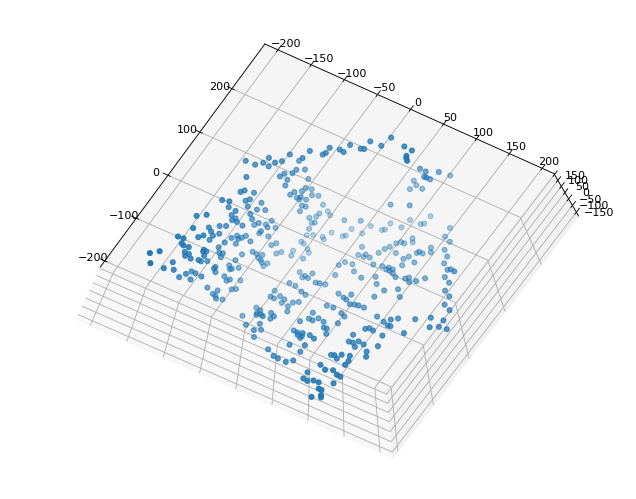

In [ ]:
A = affineSFM(track_x, track_y, -80, -30)

### Write-up (20 pt)


*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible.



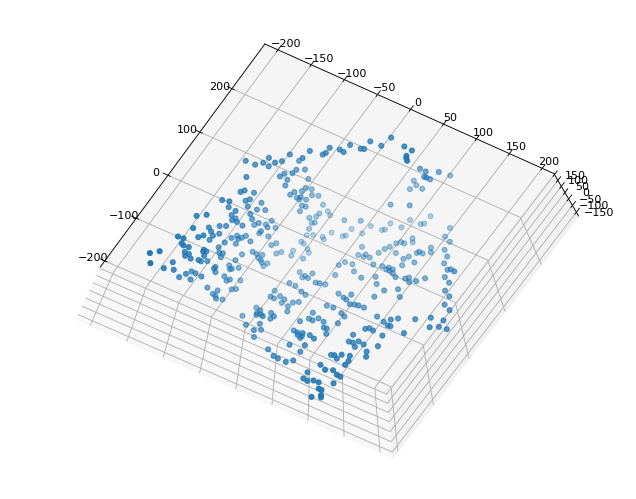

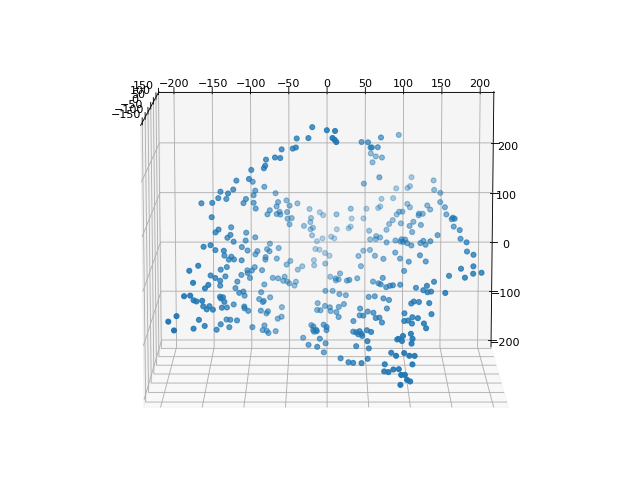

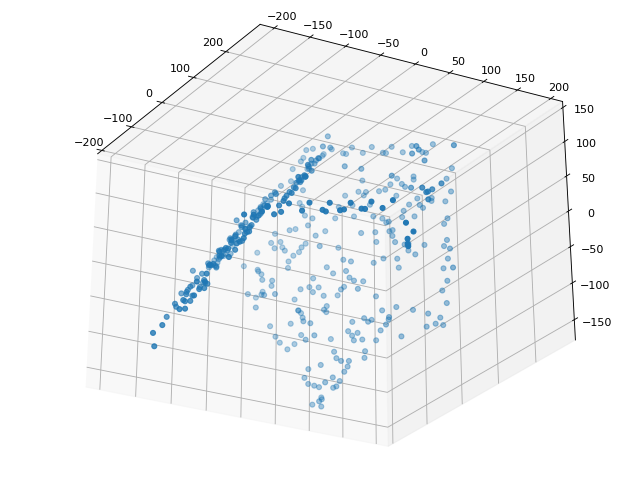

In [ ]:
affineSFM(track_x, track_y, -80, -30)
affineSFM(track_x, track_y, -80, 0)
temp = affineSFM(track_x, track_y, -30, -30)

*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k 
<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->

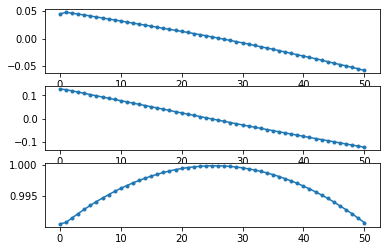

In [ ]:
  a1 = A[::2]                                                                   # select alternate columns from 0th row of A matrix
  root_a1 = np.linalg.norm(a1, axis=1)                                          # normalize the matrix
  a1 = a1/root_a1[:,None]
  
  a2 = A[1::2]                                                                  # select alternate columns from 0th row of A matrix
  root_a2 = np.linalg.norm(a2, axis=1)                                          # normalize the matrix           
  a2 = a2/root_a2[:,None]                                                     
 
  a_fin = np.cross(a1,a2)
  time = np.linspace(0, 50, 51)

  fig, (ax1, ax2, ax3) = plt.subplots(3, 1) 
  ax1.plot(time, a_fin[:, 0], '.-')                                             # plot x w.r.t time
  ax2.plot(time, a_fin[:, 1], '.-')                                             # plot y w.r.t time
  ax3.plot(time, a_fin[:, 2], '.-')                                             # plot z w.r.t time
  plt.show()

### Hint


*   Do not use existing structure from motion code, such as found in OpenCV.
*   The provided file tracks.mat contains the tracked keypoints over 51 frames.viewpoints. 
*   Reference: 
    - Tomasi and Kanade. Shape and Motion from Image Streams under Orthography: a Factorization Method. 1992